# Tabular Playground Series Sep 2022

For this challenge, you will be predicting a full year worth of sales for 4 items from two competing stores located in six different countries. This dataset is completely fictional, but contains many effects you see in real-world data, e.g., weekend and holiday effect, seasonality, etc. You are given the challenging task of predicting book sales during the year 2021.

#### Data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

In [4]:
train_data_row, train_data_col = train_data.shape
print('Total rows: ', train_data_row)
print('Total columns: ', train_data_col)

Total rows:  70128
Total columns:  6


In [5]:
train_data.head()

,row_id,date,country,store,product,num_sold
0,0,2017-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,663
1,1,2017-01-01,Belgium,KaggleMart,Kaggle Getting Started,615
2,2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480
3,3,2017-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710
4,4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240


In [6]:
train_data.tail()

,row_id,date,country,store,product,num_sold
70123,70123,2020-12-31,Spain,KaggleMart,Kaggle for Kids: One Smart Goose,614
70124,70124,2020-12-31,Spain,KaggleRama,Kaggle Advanced Techniques,215
70125,70125,2020-12-31,Spain,KaggleRama,Kaggle Getting Started,158
70126,70126,2020-12-31,Spain,KaggleRama,Kaggle Recipe Book,135
70127,70127,2020-12-31,Spain,KaggleRama,Kaggle for Kids: One Smart Goose,202


## Data Understanding

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70128 entries, 0 to 70127
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   row_id    70128 non-null  int64 
 1   date      70128 non-null  object
 2   country   70128 non-null  object
 3   store     70128 non-null  object
 4   product   70128 non-null  object
 5   num_sold  70128 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 3.2+ MB


In [8]:
# Formatting date column
train_data['date'] = pd.to_datetime(train_data['date'])
train_data['year'] = train_data['date'].dt.year
train_data['month'] = train_data['date'].dt.month
train_data['day'] = train_data['date'].dt.day
train_data['dayOfYear'] = train_data['date'].dt.dayofyear
train_data['weekday'] = train_data['date'].dt.weekday

test_data['date'] = pd.to_datetime(test_data['date'])
test_data['year'] = test_data['date'].dt.year
test_data['month'] = test_data['date'].dt.month
test_data['day'] = test_data['date'].dt.day
test_data['dayOfYear'] = test_data['date'].dt.dayofyear
test_data['weekday'] = test_data['date'].dt.weekday


In [9]:
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
row_id,70128.0,35063.500000,20244.354176,0.0,17531.75,35063.5,52595.25,70127.0
num_sold,70128.0,194.296986,126.893874,19.0,95.00,148.0,283.00,986.0
year,70128.0,2018.501027,1.118348,2017.0,2018.00,2019.0,2020.00,2020.0
month,70128.0,6.522930,3.448728,1.0,4.00,7.0,10.00,12.0
day,70128.0,15.729637,8.800155,1.0,8.00,16.0,23.00,31.0
dayOfYear,70128.0,183.125257,105.439394,1.0,92.00,183.0,274.00,366.0
weekday,70128.0,2.997947,2.000526,0.0,1.00,3.0,5.00,6.0


In [10]:
print("duplicated data :", train_data.duplicated().sum())
print("null data : ", train_data.isnull().sum().sum())

duplicated data : 0
null data :  0


In [11]:
for col in train_data.columns:
    print(col, len(train_data[col].unique()))

row_id 70128
date 1461
country 6
store 2
product 4
num_sold 699
year 4
month 12
day 31
dayOfYear 366
weekday 7


### EDA

In [12]:
train_data.head()

,row_id,date,country,store,product,num_sold,year,month,day,dayOfYear,weekday
0,0,2017-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,663,2017,1,1,1,6
1,1,2017-01-01,Belgium,KaggleMart,Kaggle Getting Started,615,2017,1,1,1,6
2,2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480,2017,1,1,1,6
3,3,2017-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710,2017,1,1,1,6
4,4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240,2017,1,1,1,6


Text(0.5, 1.0, 'Total Store Sales')

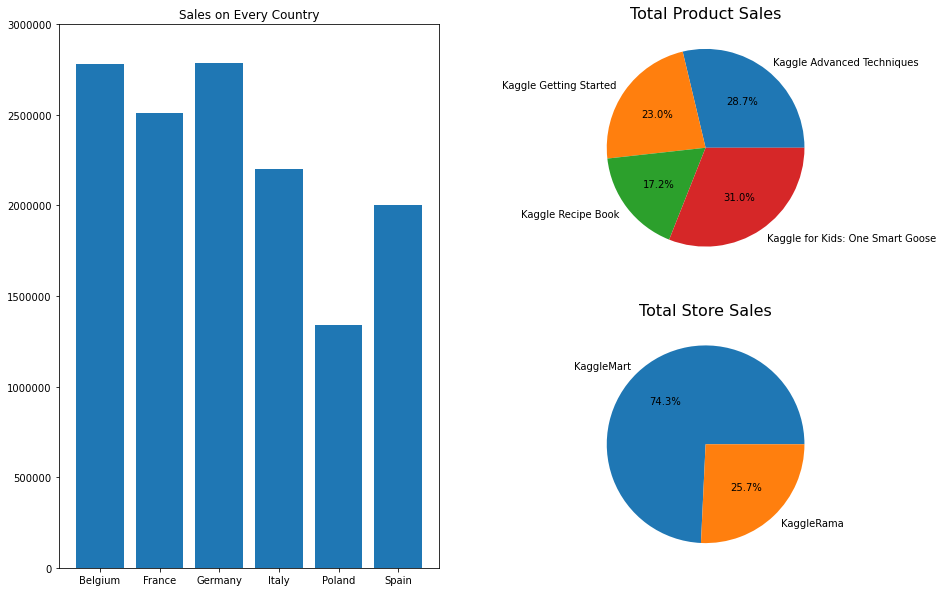

In [139]:
sold_product = train_data.groupby(['product'])['num_sold'].sum()
sold_store = train_data.groupby(['store'])['num_sold'].sum()
sold_country = train_data.groupby(['country'])['num_sold'].sum()

fig = plt.figure(figsize=(15,10))
fig.set_facecolor('white')

ax1 = fig.add_subplot(1, 2, 1)
ax1.bar(sold_country.keys(), sold_country.values)
ax1.set_title('Sales on Every Country')
ax1.ticklabel_format(style='plain', axis='y')
ax1.set_ylim(0, 3e6)

ax2 = fig.add_subplot(2, 2, 2)
ax2.pie(sold_product.values, labels=sold_product.keys(), autopct="%.1f%%")
ax2.set_title('Total Product Sales', fontsize=16)

ax3 = fig.add_subplot(2, 2, 4)
ax3.pie(sold_store.values, labels=sold_store.keys(), autopct="%.1f%%")
ax3.set_title('Total Store Sales', fontsize=16)

Text(0.5, 1.0, 'Product Sales by Store')

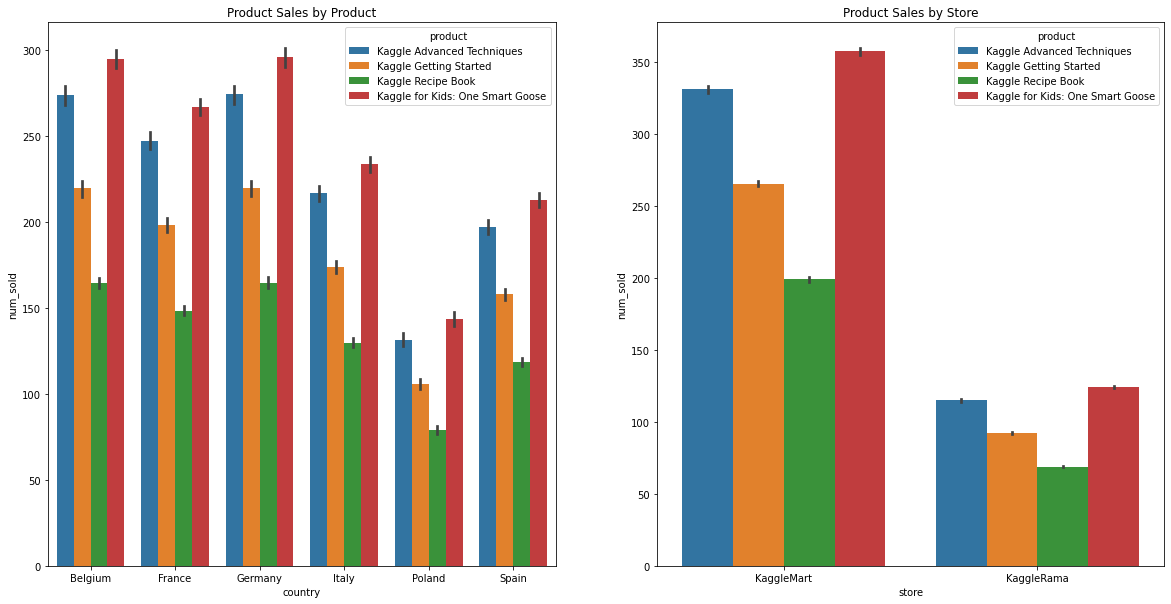

In [145]:
fig = plt.figure(figsize=(20,10))
fig.set_facecolor('white')

ax1 = fig.add_subplot(1, 2, 1)
sns.barplot(data=train_data, x='country', y='num_sold', hue='product')
ax1.set_title('Product Sales by Product')

ax2 = fig.add_subplot(1, 2, 2)
sns.barplot(data=train_data, x='store', y='num_sold', hue='product')
ax2.set_title("Product Sales by Store")